# Computer Vision 1: Image Preprocessing

This notebook is based on fastai's **[Chapter 7](https://github.com/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb)**.

Please read that chapter before looking at this review.

*I suggest opening this notebook in Colab (where it can be easier to use GPU).*
*If you want to run it locally, set up the **deep-learning** environment in your terminal with `conda env create -f environment.yml` and activate it in your preferred IDE.*

In [1]:
### FOR COLAB USERS ###
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.0 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
# ### FOR LOCAL USERS ###
# import fastai
# print(fastai.__version__)

# ! pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.all import *

# Data

In [4]:
# download
path = untar_data(URLs.IMAGENETTE)

# data block
dblock = DataBlock(
  blocks=(
    ImageBlock(), # x = images
    CategoryBlock() # y = categories
  ),
  get_items=get_image_files,
  get_y=parent_label,
  item_tfms=Resize(460), # presizing
  batch_tfms=aug_transforms(size=224, min_scale=0.75) # augmentation
)

# data loaders
dls = dblock.dataloaders(path, bs=64)

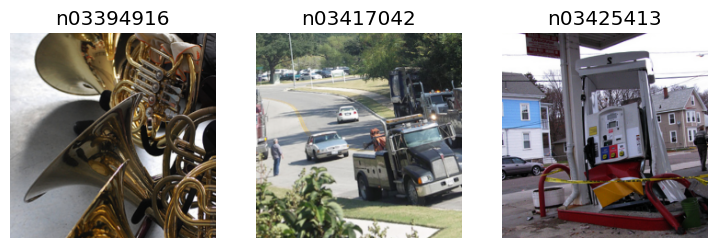

In [5]:
# show images
dls.show_batch(nrows=1, ncols=3)

In [6]:
# raw data -- batch
x,y = dls.one_batch()
print(x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [7]:
# raw data -- single sample
sample_x, sample_y = x[0],y[0]
print(sample_x.shape, sample_y.shape)

torch.Size([3, 224, 224]) torch.Size([])


In [8]:
# baseline model
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.564704,3.665846,0.319642,00:51
1,1.192906,1.354671,0.535101,00:50
2,0.937918,1.678945,0.566468,00:49
3,0.703364,0.754956,0.761016,00:49
4,0.583175,0.549764,0.828230,00:49


# Normalize the data
- Most images and computer vision libraries use values between 0 and 255 for pixels, or between 0 and 1. In either case, your data is not going to have a mean of 0 and a standard deviation of 1
- You should normalize the inputs before training a model
- This is especially important when using pretrained models -- the pretrained model only knows how to work with data of the type that it has seen before. If the average pixel value was 0 in the data it was trained with, but your data has 0 as the minimum possible value of a pixel, then the model is going to be seeing something very different to what is intended
- When you distribute a model, you need to also distribute the statistics used for normalization, since anyone using it for inference, or transfer learning, will need to use the same statistics
- If you're using a model that someone else has trained, make sure you find out what normalization statistics they used, and match them

### Aside: means across dimensions

In [9]:
print("SINGLE SAMPLE")
print("MEANS -- SINGLE AXIS")
print("dim 0:", sample_x.mean(dim=[0]).shape) # pixels?
print("dim 1:", sample_x.mean(dim=[1]).shape) # channel axis
print("dim 2:", sample_x.mean(dim=[2]).shape) # unsure

SINGLE SAMPLE
MEANS -- SINGLE AXIS
dim 0: torch.Size([224, 224])
dim 1: torch.Size([3, 224])
dim 2: torch.Size([3, 224])


In [10]:
print("SINGLE SAMPLE")
print("MEANS -- MORE THAN ONE AXIS")
print("dim 0 and 1:", sample_x.mean(dim=[0,1]).shape)
print("dim 1 and 2:", sample_x.mean(dim=[1,2]).shape)
print("dim 0 and 2:", sample_x.mean(dim=[0,2]).shape)
print("dim 0,1,2:", sample_x.mean(dim=[0,1,2]).shape)

SINGLE SAMPLE
MEANS -- MORE THAN ONE AXIS
dim 0 and 1: torch.Size([224])
dim 1 and 2: torch.Size([3])
dim 0 and 2: torch.Size([224])
dim 0,1,2: torch.Size([])


In [11]:
print("BATCH")
print("MEANS -- SINGLE AXIS")
print("dim 0:", x.mean(dim=[0]).shape) # each image (x values -- independent var)
print("dim 1:", x.mean(dim=[1]).shape) # pixels?
print("dim 2:", x.mean(dim=[2]).shape) # channel axis
print("dim 3:", x.mean(dim=[3]).shape) # unsure

BATCH
MEANS -- SINGLE AXIS
dim 0: torch.Size([3, 224, 224])
dim 1: torch.Size([64, 224, 224])
dim 2: torch.Size([64, 3, 224])
dim 3: torch.Size([64, 3, 224])


In [12]:
print("BATCH")
print("MEANS -- TWO AXES")
print("dim 0 and 1:", x.mean(dim=[0,1]).shape)
print("dim 0 and 2:", x.mean(dim=[0,2]).shape)
print("dim 0 and 2:", x.mean(dim=[0,3]).shape)

BATCH
MEANS -- TWO AXES
dim 0 and 1: torch.Size([224, 224])
dim 0 and 2: torch.Size([3, 224])
dim 0 and 2: torch.Size([3, 224])


In [13]:
print("BATCH")
print("MEANS -- THREE AXES") # ignoring axis 1, which is channel axis
print("dim 0,2,3 mean:", x.mean(dim=[0,2,3]).shape)
print("dim 0,2,3 std:", x.std(dim=[0,2,3]).shape)

BATCH
MEANS -- THREE AXES
dim 0,2,3 mean: torch.Size([3])
dim 0,2,3 std: torch.Size([3])


### Means / SD of non-normalized data

In [14]:
# single sample
# don't include axis 0 because that's a channel axis
sample_x.mean(dim=[1,2]), sample_x.std(dim=[1,2])

(TensorImage([0.3815, 0.3471, 0.0906], device='cuda:0'),
 TensorImage([0.2618, 0.2096, 0.1319], device='cuda:0'))

In [15]:
# batch
# don't include axis 1 because that's a channel axis
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([0.4558, 0.4570, 0.4381], device='cuda:0'),
 TensorImage([0.2777, 0.2786, 0.3086], device='cuda:0'))

### Normalization Process

In [16]:
def get_dls(batch_size, image_size):
  """
  Get datablock of a certain batch size and image size
  Normalize transform is a batch transform
  """
  dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=[
        *aug_transforms(size=image_size, min_scale=0.75),
        Normalize.from_stats(*imagenet_stats) # could replace this with a mean/sd you want
    ]
  )

  return dblock.dataloaders(path, bs=batch_size)

In [17]:
# get the normalized images
batch_size = 64
image_size = 224

dls = get_dls(batch_size, image_size)

In [18]:
# look at means / sd again
x,y = dls.one_batch()
x.mean(dim=[0,2,3]),x.std(dim=[0,2,3])

(TensorImage([-0.0391,  0.0526,  0.1048], device='cuda:0'),
 TensorImage([1.1825, 1.1883, 1.2852], device='cuda:0'))

In [19]:
# train normalized model
model = xresnet50(n_out=dls.c)

learn = Learner(
  dls,
  model,
  loss_func=CrossEntropyLossFlat(),
  metrics=accuracy
)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.624983,2.136752,0.386482,00:49
1,1.264982,1.333777,0.579910,00:50
2,1.003049,1.596672,0.572442,00:49
3,0.745061,0.725158,0.774085,00:50
4,0.615985,0.587952,0.815907,00:49


# Progressive Resizing
- Another form of data augmentation -- helps with generalization
- Start training using small images, and end training using large images
- Spending most of the epochs training with small images helps training complete much faster
- Completing training using large images makes the final accuracy much higher
- The kinds of features that are learned by convolutional neural networks are not in any way specific to the size of the image. Early layers find things like edges and gradients, and later layers may find things like noses and sunsets. So when we change image size in the middle of training, it doesn't mean that we have to find totally different parameters for our model
- Fine-tune after you resize the images (because the process is like transfer learning)

Caveat:
- Note that for transfer learning, progressive resizing may actually hurt performance. This is most likely to happen if your pretrained model was quite similar to your transfer learning task and dataset and was trained on similar-sized images, so the weights don't need to be changed much. In that case, training on smaller images may damage the pretrained weights.
- On the other hand, if the transfer learning task is going to use images that are of different sizes, shapes, or styles than those used in the pretraining task, progressive resizing will probably help. As always, the answer to "Will it help?" is "Try it!"

In [20]:
# start with smaller image sizes
batch_size = 128 # bigger batch size (initially: 64)
image_size = 128 # smaller images than before (initially: 224)

dls = get_dls(batch_size, image_size)

In [21]:
# create a learner with the new dataset
learn = Learner(
  dls, # data with a smaller size
  xresnet50(n_out=dls.c), # same model as before
  loss_func=CrossEntropyLossFlat(),
  metrics=accuracy
)

# train on initial epochs
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.627224,2.088807,0.422704,00:32
1,1.263832,1.878202,0.469380,00:32
2,0.961043,0.863219,0.735624,00:32
3,0.747457,0.668607,0.787528,00:32


In [22]:
# replace dataloaders with images of a larger size
batch_size = 64
image_size = 224
learn.dls = get_dls(batch_size, image_size)

# fine-tune using larger images
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.849177,1.187689,0.656833,00:49


epoch,train_loss,valid_loss,accuracy,time
0,0.641260,0.674827,0.794623,00:50
1,0.649627,1.171515,0.697909,00:49
2,0.594484,0.565184,0.821882,00:50
3,0.492267,0.477090,0.856609,00:49
4,0.434000,0.454687,0.857730,00:50


# Test Time Augmentation
- During inference or validation, create multiple versions of each image, using data augmentation, and then take the average or maximum of the predictions for each augmented version of the image
- Instead of using a center crop, select a number of areas to crop from the original rectangular image, pass each of them through our model, and take the maximum or average of the predictions
- Do this not just for different crops, but for different values across all of our test time augmentation parameters
- Depending on the dataset, test time augmentation can result in dramatic improvements in accuracy
- It does not change the time required to train, but will increase the amount of time required for validation or inference by the number of test-time-augmented images requested

In [23]:
# add TTA to the learner -- uses validation set by default
preds,targs = learn.tta() # uses unaugmented center crop image + 4 randomly augmented images

# gives a good boost in performance with no additional training required (but inference is slower)
accuracy(preds, targs).item()

0.8644511103630066

# Mixup
- Powerful data augmentation technique that can provide dramatically higher accuracy, especially when you don't have much data and don't have a pretrained model that was trained on data similar to your dataset
- Allows you to "dial up" or "dial down" the amount of augmentation, to see what works best for you
- Good for reducing overfitting
- Takes a linear combination of images. For each image: Select another image from your dataset at random. Pick a weight at random. Create the IV: take a weighted average (using the random weight) of the selected image with your image. Create the DV: take a weight average (with the same random weight) of this image's labels with your image's labels
- Targets (DV) need to be one-hot encoded
- Note: You can use mixup for types of data other than photos, like NLP -- can even use Mixup on activations inside the models (not just on inputs)

### Pseudocode
```
# select another image from your dataset at random
image2,target2 = dataset[randint(0,len(dataset))]

# pick a weight at random
t = 0.6

# create the IV: a weighted average of the random image with your image
new_image = t * image1 + (1-t) * image2

# create the DV: a weighted average of the random image's labels with your image's labels
new_target = t * target1 + (1-t) * target2
```

### Example

#### Get two images
- Multiclass targets: `[cat, flower, church, bike, airplane, shark, camera, gas station, museum, stone]`
- Church would have a multiclass encoding like `[0,0,1,0,0,0,0,0,0,0]`
- Gas station would have a multiclass encoding like `[0,0,0,0,0,0,0,1,0,0]`

In [24]:
# get church and gas station images
church = PILImage.create(get_image_files_sorted(path/'train'/'n03028079')[0])
gas = PILImage.create(get_image_files_sorted(path/'train'/'n03425413')[0])

church = church.resize((256,256))
gas = gas.resize((256,256))

tchurch = tensor(church).float() / 255.
tgas = tensor(gas).float() / 255.

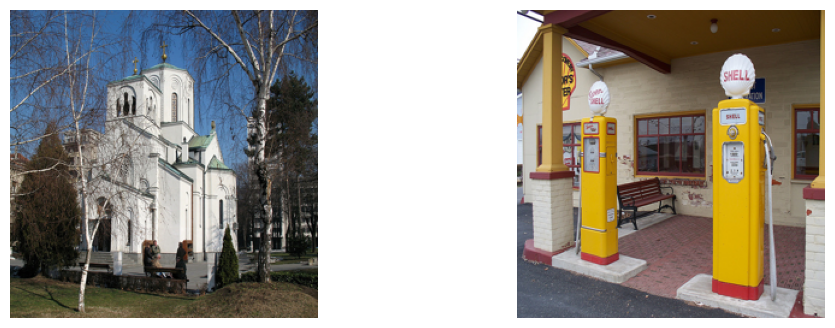

In [25]:
# show the church and gas station images
_,axs = plt.subplots(1, 2, figsize=(12,4))
show_image(tchurch, ax=axs[0]);
show_image(tgas, ax=axs[1]);

#### Do the mixup
- The multiclass activation should be something like `[0,0,0.3,0.0.0.0.0.7,0,0]` -- the linear combination of the one-hot-encoded targets

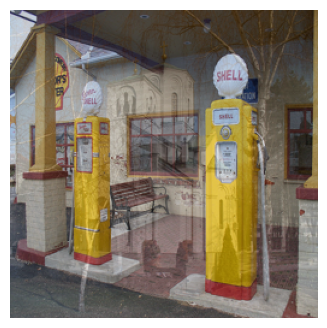

In [26]:
# show the mixup -- 30% church, 70% gas station
_,axs = plt.subplots(1, 1, figsize=(12,4))
show_image((0.3*tchurch + 0.7*tgas), ax=axs);

#### Predict
- What should a classifier predict?
- The right answer is 30% church and 70% gas station
- To get answer, take the linear combination of one-hot-encoded targets
- Need many more epochs (like >80)

In [27]:
# put mixup in learner using a callback (way to customize learner)
model = xresnet50(n_out=dls.c)

learn = Learner(
  dls,
  model,
  loss_func=CrossEntropyLossFlat(),
  metrics=accuracy,
  cbs=MixUp()
)

# note that this is not great -- really need >80 epochs to train well
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.913496,4.096669,0.272218,00:33
1,1.692600,1.569083,0.502240,00:33
2,1.487177,0.993001,0.703510,00:33
3,1.300069,0.814721,0.758402,00:33
4,1.192670,0.716725,0.785661,00:33


# Label Smoothing
- In classification problems, our targets are one-hot encoded: The model is trained to return 0 for all categories but one, for which it is trained to return 1. Even 0.999 is not "good enough". The model will get gradients and learn to predict activations with even higher confidence. This encourages overfitting and gives you at inference time a model that is not going to give meaningful probabilities: it will always say 1 for the predicted category even if it's not too sure, just because it was trained this way
- This can become very harmful if your data is not perfectly labeled
- Label smoothing = replace all our 1s with a number a bit less than 1, and our 0s by a number a bit more than 0, and then train
- By encouraging your model to be less confident, label smoothing will make your training more robust, even if there is mislabeled data. The result will be a model that generalizes better

### Doing it
- Start with one-hot-encoded labels, then replace all 0s with e/N and all 1s with 1-e+(e/N)
- e = parameter -- usually 0.1 (meaning we are 10% unsure of our labels)
- N = number of classes
- Example: changing `[0,0,0,1,0,0,0,0,0,0]` to `[0.01,0.01,0.01,0.91,0.01,0.01,0.01,0.01,0.01,0.01]`

In [28]:
model = xresnet50(n_out=dls.c)

# only loss function is different
learn = Learner(
  dls,
  model,
  loss_func=LabelSmoothingCrossEntropy(), # here's our label smoothing
  metrics=accuracy
)

# like with mixup, you need way more epochs to see improvements
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.741263,2.250363,0.477595,00:34
1,1.521508,1.660700,0.546677,00:33
2,1.283191,1.238358,0.712845,00:33
3,1.133661,1.077511,0.771471,00:34
4,1.023396,0.986642,0.817401,00:33
